<a href="https://colab.research.google.com/github/farnoush-zeidi/Info_Ret/blob/main/HVD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Data Generation and Preprocessing**


We will take the following steps to preprocess the data:



1.   Match data with the corresponding labels in one dataframe
2.   transform input data and create column text: Premist + Conclusion + Stance



**Input:** *arguments-training.tsv, arguments-validation.ts*

**Output:** *train_full.csv, validation_full.csv*

We will use this structure for 4 different datasets that we want to train

In [15]:
from google.colab import drive
drive.mount('/content/drive')
data_path ='/content/drive/MyDrive/InfoRet/data/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import csv

def create_data_file(path_to_arguments, path_to_labels, output_path=None, drop_duplicates=True):
    """
    Create a data file by merging arguments and labels from the corresponding_files from two files using pandas library.

    Args:
        path_to_arguments (str): File path to the template file.
        path_to_labels (str): File path to the labels file.
        output_path (str, optional): File path to save the output data file.
        drop_duplicates (bool, optional): Whether to drop duplicate rows in the output data file.

    Returns:
        pandas.DataFrame: Merged data with duplicate rows dropped (if drop_duplicates is True).
    """

    # Load Arguments & Concat Premise Stance Conclusion
    df_arguments = pd.read_csv(path_to_arguments, sep='\t', quoting=csv.QUOTE_NONE, encoding="utf-8", header=0)
    df_arguments["text"] = df_arguments["Premise"] + " " + df_arguments["Stance"] + " " + df_arguments["Conclusion"]

    # Load Labels & Convert to Ints and Create Column with List of Label Names
    df_labels = pd.read_csv(path_to_labels, sep='\t', quoting=csv.QUOTE_NONE, encoding="utf-8", header=0)

    for col in df_labels.columns[1:]:
        df_labels[col] = df_labels[col].astype(int)

    df_labels['category'] = df_labels.apply(lambda row: [col for col in df_labels.columns if row[col] == 1], axis=1)

    # Reorder Columnames
    cols = df_labels.columns.tolist()
    new_cols = cols[:-1]      # All columns except the last one
    new_cols.insert(1, cols[-1])  # Insert the last column to the second position
    df_labels = df_labels[new_cols]

    # Merge Data based on ID
    df_merged = pd.merge(df_arguments, df_labels, on=["Argument ID"])

    if drop_duplicates:
        df_merged = df_merged.drop_duplicates(subset=["text"])

    if output_path:
        df_merged.to_csv(output_path)

    return df_merged


## **First data**

In [ ]:
train_df = create_data_file(data_path + "arguments-training.tsv", data_path + "labels-training.tsv", data_path + "generated_data/"+"arg_training_label_task.csv")
val_df = create_data_file(data_path + "arguments-validation.tsv", data_path + "labels-validation.tsv", data_path +"generated_data/"+ "arg_validation_label_task.csv")
test_df = create_data_file(data_path + "arguments-test.tsv", data_path + "labels-test.tsv", data_path +"generated_data/"+ "arg_test_label_task.csv")

##**Second data** (Zhihu)

In [ ]:
test_df = create_data_file(data_path + "arguments-validation-zhihu.tsv", data_path + "labels-validation-zhihu.tsv", data_path +"generated_data/"+ "arg_validation_label_zhihu_task.csv")

##**Third data**  (nahjalbalagha)

In [ ]:
test_df = create_data_file(data_path + "arguments-test-nahjalbalagha.tsv", data_path + "labels-test-nahjalbalagha.tsv", data_path +"generated_data/"+ "arg_test_label_nahjalbalagha_task.csv")

##**Fourth data** (nyt)

In [ ]:
test_df = create_data_file(data_path + "arguments-test-nyt.tsv", data_path + "labels-test-nyt.tsv", data_path +"generated_data/"+ "arg_test_label_nyt_task.csv")

In [ ]:
print("len of train_df:",len(train_df))
print("len of val_df:",len(val_df))
print("len of test_df:",len(test_df))

# **Train Language Models to Detect Human Values in Arguments**

In [ ]:
!pip install simpletransformers

In [ ]:
import pandas as pd
import logging
import json
from argparse import ArgumentParser
from simpletransformers.classification import (
    MultiLabelClassificationModel, MultiLabelClassificationArgs
)
from sklearn.metrics import f1_score, precision_recall_curve, precision_recall_fscore_support, classification_report

logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)


##**Data preparation for the SimpleTransformers**

 Data preparation for the SimpleTransformers
If the dataframe has a header row, the text column should have the heading text and the labels column should have the heading labels.

https://simpletransformers.ai/docs/classification-data-formats/

In [ ]:
def prepare_labels(df):
    labels = []
    for _, row in df.iterrows():
        text = row['text']
        label = row[df.columns[7:]].tolist()

        assert (len(label) == 20)
        labels.append([text, label])

    processed_df = pd.DataFrame(labels, columns=['text', 'labels'])
    return processed_df


train = pd.read_csv(data_path + "generated_data/"+"arg_training_label_task.csv")
valid = pd.read_csv(data_path + "generated_data/"+"arg_validation_label_task.csv")
test = pd.read_csv(data_path + "generated_data/"+"arg_test_label_task.csv")
#test = pd.read_csv(data_path + "generated_data/"+"arg_validation_label_zhihu_task.csv")
#test = pd.read_csv(data_path + "generated_data/"+"arg_test_label_nahjalbalagha_task.csv")
#test = pd.read_csv(data_path + "generated_data/"+"arg_test_label_nyt_task.csv")




print("prepare labels ...")
train_df = prepare_labels(train)
val_df = prepare_labels(valid)
test_df = prepare_labels(test)

prepare labels ...


In [ ]:
train_df

## **Model configuration**

In [ ]:
import torch

# Check if CUDA is available
cuda_available = torch.cuda.is_available()

# Print the result
if cuda_available:
    print("CUDA is available. Using GPU.")
else:
    print("CUDA is not available. Using CPU.")

CUDA is available. Using GPU.


In [ ]:
# Optional model configuration
models_path ='/content/drive/MyDrive/InfoRet/models/'
model_type="bert" #mlm+nsp  #alternative model_type : roberta/ albert/ ... (ref to https://simpletransformers.ai/docs/classification-specifics/#supported-model-types)
model_name="google-bert/bert-base-uncased" #This may be a Hugging Face Transformers compatible pre-trained model, a community model, or the path to a directory containing model files. (ref to https://simpletransformers.ai/docs/classification-models/ )

#model_type="roberta" #mlm _restrucer of model
#model_name="FacebookAI/roberta-base"

#model_type="albert" #mlm+sop _restrucer of model
#model_name="albert/albert-base-v2"

model_args = MultiLabelClassificationArgs(num_train_epochs=12)
model_args.train_batch_size =16
model_args.evaluate_during_training = True
model_args.overwrite_output_dir = True
model_args.output_dir = f"{models_path}{model_name}"
model_args.best_model_dir = f"{models_path}{model_name}/best_model"
model_args.save_model_every_epoch = True
model_args.save_eval_checkpoints = False
# model_args.report_to="wandb" # enable logging to W&B
# model_args.run_name=str(model_name),  # name of the W&B run (optional)

# Create a MultiLabelClassificationModel
model = MultiLabelClassificationModel(
    model_type,
    model_name,
    num_labels=20,
    args=model_args,
    use_cuda=True

    )



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForMultiLabelSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Some weights of BertForMultiLabelSequenceClassification were not initialized
from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

In [ ]:
# Train the model
model.train_model(train_df, eval_df=val_df)

In [ ]:
# test result for each lable
values = [
    "Self-direction: thought",
    "Self-direction: action",
    "Stimulation",
    "Hedonism",
    "Achievement",
    "Power: dominance",
    "Power: resources",
    "Face",
    "Security: personal",
    "Security: societal",
    "Tradition",
    "Conformity: rules",
    "Conformity: interpersonal",
    "Humility",
    "Benevolence: caring",
    "Benevolence: dependability",
    "Universalism: concern",
    "Universalism: nature",
    "Universalism: tolerance",
    "Universalism: objectivity"
]


def write_pr_rc_f1_to_file(path, pr, rc, f1):
    with open(f'{path}/metrics.txt', "w") as f:
        f.write(f"pr: {str(pr)}")
        f.write("\n")
        f.write(f"rc:  {str(rc)}")
        f.write("\n")
        f.write(f"f1: {str(f1)}")



def write_text(filename, text):
    with open(filename, "w") as f:
        # f.write(text)
        f.write(json.dumps(text))
        f.write('\n')




result_path =f'/content/drive/MyDrive/InfoRet/models/{model_name}/best_model/'

predictions, _ = model.predict(test_df['text'].tolist())
gold_label = test_df['labels'].tolist()
pr, rc, f1, sup = precision_recall_fscore_support(gold_label, predictions, average="macro",  zero_division=1)
write_pr_rc_f1_to_file(path=f"{result_path}", pr=pr, rc=rc, f1=f1)

report = classification_report(gold_label, predictions, target_names=values, output_dict=True,  zero_division=1)
print(report)
write_text(f"{result_path}/classification_report_metric.txt", report)

print(f"clssification_on_{model_name} is done!")

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

{'Self-direction: thought': {'precision': 1.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 142}, 'Self-direction: action': {'precision': 0.30892857142857144, 'recall': 0.4481865284974093, 'f1-score': 0.3657505285412262, 'support': 386}, 'Stimulation': {'precision': 0.056511056511056514, 'recall': 0.9078947368421053, 'f1-score': 0.1063993831919815, 'support': 76}, 'Hedonism': {'precision': 0.016795865633074936, 'recall': 1.0, 'f1-score': 0.03303684879288438, 'support': 26}, 'Achievement': {'precision': 0.2615803814713896, 'recall': 0.9504950495049505, 'f1-score': 0.41025641025641024, 'support': 404}, 'Power: dominance': {'precision': 0.06722689075630252, 'recall': 1.0, 'f1-score': 0.12598425196850394, 'support': 104}, 'Power: resources': {'precision': 0.06692657569850552, 'recall': 1.0, 'f1-score': 0.12545676004872106, 'support': 103}, 'Face': {'precision': 0.061653116531165314, 'recall': 0.9479166666666666, 'f1-score': 0.11577608142493641, 'support': 96}, 'Security: personal': {'precisi

## **Make confusion matrix**

In [ ]:
# for each layer
from sklearn.metrics import multilabel_confusion_matrix

# Compute the multilabel confusion matrix
mcm = multilabel_confusion_matrix(gold_label, predictions)
confusion_matrices = {}
# Print the confusion matrix for each class
for i, label in enumerate(values):
    # print(f"Confusion Matrix for {label}:")
    # print(mcm[i])
    confusion_matrices[label] = mcm[i]


confusion_matrices

In [ ]:
# total confusion matrix
import numpy as np
from sklearn.metrics import multilabel_confusion_matrix



# Compute the multilabel confusion matrix for each class
mcm = multilabel_confusion_matrix(gold_label, predictions)

# Aggregate the confusion matrices across all classes
total_mcm = np.sum(mcm, axis=0)

# Print the total multilabel confusion matrix
print("Total Multilabel Confusion Matrix:")
print(total_mcm)

total_mcm=pd.DataFrame(total_mcm)

In [ ]:
#saving confusion matrix

#csv_file_path = '/content/drive/My Drive/InfoRet/results/matrix/confusion_matrices_firstdataBBUlabels.csv'
#csv_file_path = '/content/drive/My Drive/InfoRet/results/matrix/confusion_matrices_zhihutdataBBUlabels.csv'
#csv_file_path = '/content/drive/My Drive/InfoRet/results/matrix/confusion_matrices_nhjtdataBBUlabels.csv'
#csv_file_path = '/content/drive/My Drive/InfoRet/results/matrix/confusion_matrices_nyttdataBBUlabels.csv'

#csv_file_path = '/content/drive/My Drive/InfoRet/results/matrix/confusion_matrices_firstdataRoBERTalabels.csv'
#csv_file_path = '/content/drive/My Drive/InfoRet/results/matrix/confusion_matrices_zhihudataRoBERTalabels.csv'
#csv_file_path = '/content/drive/My Drive/InfoRet/results/matrix/confusion_matrices_nhjdataRoBERTalabels.csv'
#csv_file_path = '/content/drive/My Drive/InfoRet/results/matrix/confusion_matrices_nytdataRoBERTalabels.csv'

#csv_file_path = '/content/drive/My Drive/InfoRet/results/matrix/confusion_matrices_firstdataAlBERTlabels.csv'
#csv_file_path = '/content/drive/My Drive/InfoRet/results/matrix/confusion_matrices_zhihudataAlBERTlabels.csv'
#csv_file_path = '/content/drive/My Drive/InfoRet/results/matrix/confusion_matrices_nhjdataAlBERTlabels.csv'
#csv_file_path = '/content/drive/My Drive/InfoRet/results/matrix/confusion_matrices_nytdataAlBERTlabels.csv'

confusion_matrix.to_csv(csv_file_path, index=False)

#BERT
#csv_file_path = '/content/drive/My Drive/InfoRet/results/matrix/confusion_matrices_firstdataBBUtotal.csv'
#csv_file_path = '/content/drive/My Drive/InfoRet/results/matrix/confusion_matrices_zhihudataBBUtotal.csv'
#csv_file_path = '/content/drive/My Drive/InfoRet/results/matrix/confusion_matrices_nhjdataBBUtotal.csv'
csv_file_path = '/content/drive/My Drive/InfoRet/results/matrix/confusion_matrices_nytdataBBUtotal.csv'

#RoBERTa
#csv_file_path = '/content/drive/My Drive/InfoRet/results/matrix/confusion_matrices_firstdataRoBERTatotal.csv'
#csv_file_path = '/content/drive/My Drive/InfoRet/results/matrix/confusion_matrices_zhihudataRoBERTatotal.csv'
#csv_file_path = '/content/drive/My Drive/InfoRet/results/matrix/confusion_matrices_nhjdataRoBERTatotal.csv'
#csv_file_path = '/content/drive/My Drive/InfoRet/results/matrix/confusion_matrices_nytdataRoBERTatotal.csv'

#AlBERT
#csv_file_path = '/content/drive/My Drive/InfoRet/results/matrix/confusion_matrices_firstdataAlBERTtotal.csv'
#csv_file_path = '/content/drive/My Drive/InfoRet/results/matrix/confusion_matrices_zhihudataAlBERTtotal.csv'
# csv_file_path = '/content/drive/My Drive/InfoRet/results/matrix/confusion_matrices_nhjdataAlBERTtotal.csv'
#csv_file_path = '/content/drive/My Drive/InfoRet/results/matrix/confusion_matrices_nytdataAlBERTtotal.csv'



total_mcm.to_csv(csv_file_path, index=False)

## **Making report table**

In [ ]:
import pandas as pd

def report_to_dataframe(report):
    data = []
    for label, metrics in report.items():
        data.append([label, metrics['precision'], metrics['recall'], metrics['f1-score'], metrics['support']])
    df = pd.DataFrame(data, columns=['Label', 'Precision', 'Recall', 'F1-Score', 'Support'])
    return df



#merged_df = pd.DataFrame({'all score': [pr, rc, f1, sup]})

# Convert report to DataFrame
df = report_to_dataframe(report)

# New row to be added at the beginning of the DataFrame
new_row = {"Label": "all", "Precision": pr, "Recall": rc, "F1-Score": f1, "Support": sup}

# Convert the dictionary into a DataFrame
All = pd.DataFrame([new_row])
df2 = pd.DataFrame(All)
merged_df = pd.concat([df2, df], ignore_index=True)
a=merged_df.T
a

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Label,all,Self-direction: thought,Self-direction: action,Stimulation,Hedonism,Achievement,Power: dominance,Power: resources,Face,Security: personal,...,Benevolence: caring,Benevolence: dependability,Universalism: concern,Universalism: nature,Universalism: tolerance,Universalism: objectivity,micro avg,macro avg,weighted avg,samples avg
Precision,0.235632,1.0,0.308929,0.056511,0.016796,0.26158,0.067227,0.066927,0.061653,0.12963,...,0.160804,0.088472,0.37219,0.0,1.0,0.5,0.131977,0.235632,0.286723,0.12995
Recall,0.519896,0.0,0.448187,0.907895,1.0,0.950495,1.0,1.0,0.947917,0.013208,...,0.095808,0.211538,0.776042,0.0,0.0,0.002165,0.448953,0.519896,0.448953,0.442959
F1-Score,0.141371,0.0,0.365751,0.106399,0.033037,0.410256,0.125984,0.125457,0.115776,0.023973,...,0.120075,0.124764,0.503095,0.0,0.0,0.00431,0.203989,0.141371,0.198866,0.194129
Support,None,142,386,76,26,404,104,103,96,530,...,334,156,576,143,193,462,4682,4682,4682,4682


In [ ]:
#saving report(total)

#csv_file_path = '/content/drive/My Drive/InfoRet/results/all/allfirstdataBBU.csv'
#csv_file_path = '/content/drive/My Drive/InfoRet/results/all/allzhihudataBBU.csv'
#csv_file_path = '/content/drive/My Drive/InfoRet/results/all/allnhjdataBBU.csv'
#csv_file_path = '/content/drive/My Drive/InfoRet/results/all/allnytdataBBU.csv'

# csv_file_path = '/content/drive/My Drive/InfoRet/results/all/allfirstdataRoBERTa.csv'
#csv_file_path = '/content/drive/My Drive/InfoRet/results/all/allzhihudataRoBERTa.csv'
#csv_file_path = '/content/drive/My Drive/InfoRet/results/all/allnhjdataRoBERTa.csv'
#csv_file_path = '/content/drive/My Drive/InfoRet/results/all/allnytdataRoBERTa.csv'

#csv_file_path = '/content/drive/My Drive/InfoRet/results/all/allfirstdataAlBERT.csv'
#csv_file_path = '/content/drive/My Drive/InfoRet/results/all/allzhihudataAlBERT.csv'
# csv_file_path = '/content/drive/My Drive/InfoRet/results/all/allnhjdataAlBERT.csv'
#csv_file_path = '/content/drive/My Drive/InfoRet/results/all/allnytdataAlBERT.csv'





a.to_csv(csv_file_path, index=True)

In [ ]:
values = ["All",
    "Self-direction: thought",
    "Self-direction: action",
    "Stimulation",
    "Hedonism",
    "Achievement",
    "Power: dominance",
    "Power: resources",
    "Face",
    "Security: personal",
    "Security: societal",
    "Tradition",
    "Conformity: rules",
    "Conformity: interpersonal",
    "Humility",
    "Benevolence: caring",
    "Benevolence: dependability",
    "Universalism: concern",
    "Universalism: nature",
    "Universalism: tolerance",
    "Universalism: objectivity","","","",""
]
row_to_keep = a.iloc[3]
# Convert the selected row to a DataFrame
answer = pd.DataFrame([row_to_keep]).rename(index={3: 'F1-Score'})
# Display DataFrame with only one row
answer.columns=values
answer
#BERT #done
#csv_file_path = '/content/drive/My Drive/InfoRet/results/firstdataBBU.csv'
#csv_file_path = '/content/drive/My Drive/InfoRet/results/zhihudataBBU.csv'
#csv_file_path = '/content/drive/My Drive/InfoRet/results/nhjdataBBU.csv'
#csv_file_path = '/content/drive/My Drive/InfoRet/results/nytdataBBU.csv'




#AlBERT # done
#csv_file_path = '/content/drive/My Drive/InfoRet/results/firstdataAlBERT.csv'
#csv_file_path = '/content/drive/My Drive/InfoRet/results/zhihudataAlBERT.csv'
#csv_file_path = '/content/drive/My Drive/InfoRet/results/nhjdataAlBERT.csv'
#csv_file_path = '/content/drive/My Drive/InfoRet/results/nytdataAlBERT.csv'

#RoBERTA #done
#csv_file_path = '/content/drive/My Drive/InfoRet/results/firstdataRoBERTA.csv'
#csv_file_path = '/content/drive/My Drive/InfoRet/results/zhihudataRoBERTA.csv'
#csv_file_path = '/content/drive/My Drive/InfoRet/results/nhjdataRoBERTA.csv'
#csv_file_path = '/content/drive/My Drive/InfoRet/results/nytdataRoBERTA.csv'

# Save DataFrame to CSV file in Google Drive
answer.to_csv(csv_file_path, index=True)

In [ ]:
answer

,All,Self-direction: thought,Self-direction: action,Stimulation,Hedonism,Achievement,Power: dominance,Power: resources,Face,Security: personal,...,Benevolence: caring,Benevolence: dependability,Universalism: concern,Universalism: nature,Universalism: tolerance,Universalism: objectivity,,,,
F1-Score,0.312219,0.571429,0.0,1.0,0.0,0.428571,0.0,1.0,0.0,0.484848,...,0.173913,0.0,0.296296,0.4,0.0,0.434783,0.363636,0.312219,0.318752,0.341786


# **Comparing Results**

In [ ]:
import pandas as pd
#'/content/drive/MyDrive/InfoRet/data/'
# Replace 'file_path.csv' with the path to your CSV file
file_path = '/content/drive/MyDrive/InfoRet/results/'

#bertbase
allBERT = pd.read_csv(file_path+'allBERT.csv')

firstdataBBU = pd.read_csv(file_path+'firstdataBBU.csv')
zhihudataBBU=pd.read_csv(file_path+'zhihudataBBU.csv')
nhjdataBBU=pd.read_csv(file_path+'nhjdataBBU.csv')
nytdataBBU=pd.read_csv(file_path+'nytdataBBU.csv')


#AlBERT
allAlBERT = pd.read_csv(file_path+'allAlBERT.csv')

firstdataAlBERT = pd.read_csv(file_path+'firstdataAlBERT.csv')
zhihudataAlBERT = pd.read_csv(file_path+'zhihudataAlBERT.csv')
nhjdataAlBERT = pd.read_csv(file_path+'nhjdataAlBERT.csv')
nytdataAlBERT=pd.read_csv(file_path+'nytdataAlBERT.csv')

#RoBERTA
allRoBERTA = pd.read_csv(file_path+'allRoBERTA.csv')

firstdataRoBERTA = pd.read_csv(file_path+'firstdataRoBERTA.csv')
zhihudataRoBERTA=pd.read_csv(file_path+'zhihudataRoBERTA.csv')
nhjdataRoBERTA=pd.read_csv(file_path+'nhjdataRoBERTA.csv')
nytdataRoBERTA=pd.read_csv(file_path+'nytdataRoBERTA.csv')

#by data
allfirstdata=pd.read_csv(file_path+'allfirstdata.csv')
allzhihudata=pd.read_csv(file_path+'allzhihudata.csv')
allnhjdata=pd.read_csv(file_path+'allnhjdata.csv')
allnytdata=pd.read_csv(file_path+'allnytdata.csv')



In [ ]:
allRoBERTA

,Unnamed: 0,All,Self-direction: thought,Self-direction: action,Stimulation,Hedonism,Achievement,Power: dominance,Power: resources,Face,...,Benevolence: caring,Benevolence: dependability,Universalism: concern,Universalism: nature,Universalism: tolerance,Universalism: objectivity,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25
0,First_Data,0.435849,0.472868,0.608824,0.04878,0.312500,0.587450,0.315789,0.419355,0.183206,...,0.515723,0.173554,0.732100,0.771654,0.378223,0.373494,0.551205,0.435849,0.531315,0.561645
1,Zhihu_Data,0.409568,0.380952,0.484848,1.00000,0.666667,0.707317,0.000000,0.416667,0.500000,...,0.370370,0.000000,0.622222,0.888889,0.000000,0.511628,0.528226,0.409568,0.530758,0.527063
2,NHJ_Data,0.231624,0.097561,0.193548,0.00000,0.500000,0.544118,0.000000,0.000000,0.258065,...,0.370370,0.225806,0.258065,0.000000,0.166667,0.309524,0.320000,0.231624,0.345294,0.320752
3,NYT_Data,0.298394,0.571429,0.200000,1.00000,0.000000,0.250000,0.000000,1.000000,0.000000,...,0.375000,0.275862,0.500000,0.333333,0.000000,0.400000,0.366972,0.298394,0.367289,0.341875


In [ ]:

new_row_names = ['First_Data', 'Zhihu_Data', 'NHJ_Data','NYT_Data']  # Replace ... with your row names
#new_row_names = ['BERT', 'AlBERT', 'RoBERTA']
# Set new row names using set_index()
column_name_to_remove = 'Unnamed: 0'
merged_df.drop(columns=column_name_to_remove, inplace=True)
merged_df= merged_df.set_index(pd.Index(new_row_names))

csv_file_path = '/content/drive/My Drive/InfoRet/results/allRoBERTA.csv'
#csv_file_path = '/content/drive/My Drive/InfoRet/results/allBERT.csv'
#csv_file_path = '/content/drive/My Drive/InfoRet/results/allAlBERT.csv'

# csv_file_path = '/content/drive/My Drive/InfoRet/results/allfirstdata.csv'
# csv_file_path = '/content/drive/My Drive/InfoRet/results/allzhihudata.csv'
# csv_file_path = '/content/drive/My Drive/InfoRet/results/allnhjdata.csv'
#csv_file_path = '/content/drive/My Drive/InfoRet/results/allnytdata.csv'


# Save DataFrame to CSV file in Google Drive
merged_df.to_csv(csv_file_path, index=True)
merged_df

## **plot**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


# df = allfirstdata
# df = allzhihudata
# df = allnhjdata
# df = allnytdata
# df = allBERT
# df = allAlBERT
df = allRoBERTA
df_dimensions = df[['All']]
# Set the dimensions (column names) for plotting
dimensions = df_dimensions.columns

# Create a bar chart for each dimension
for dim in dimensions:
    plt.figure(figsize=(10, 6))
    #plt.bar(['BERT', 'ALBERT', 'RoBERTa'], df_dimensions[dim], color=['blue', 'orange', 'green'])
    plt.bar(['First_Data', 'Zhihu_Data', 'NHJ_Data','NYT_Data'], df_dimensions[dim], color=['blue', 'orange', 'green','violet'])
    plt.title(f'Total Model Representation for RoBERTa MODEL')
    plt.xlabel('DATA')
    plt.ylabel('F1 Score')
    plt.ylim(0, 1)  # Adjust the y-axis limits if needed
    plt.show()


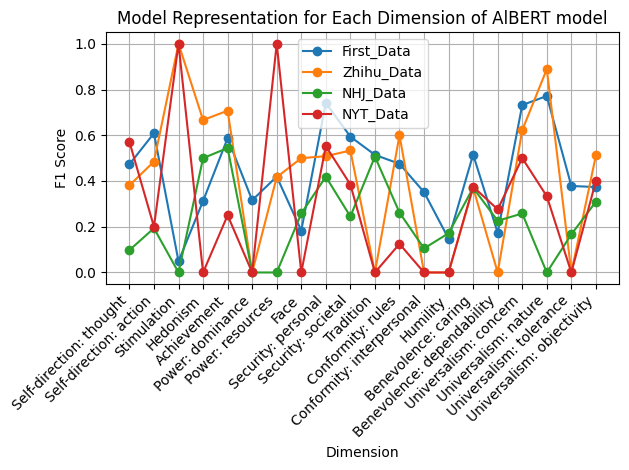

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Read CSV data into a DataFrame
#df=allfirstdata
#df=allzhihudata
#df = allnhjdata
#df = allnytdata
#df = allBERT
#df=allAlBERT
df = allRoBERTA

#df = pd.read_csv(pd.compat.StringIO(csv_data))
#df = pd.read_csv('/content/drive/My Drive/InfoRet/results/allfirstdata.csv')
df = df.rename(columns={'Unnamed: 0': 'model_name'})
# Exclude the 'All' column and select only the relevant dimensions
df_dimensions = df.drop(columns=['All'])
selected_dimensions = df_dimensions.columns[1:21]  # Exclude 'Model Name'

#Create a line plot for each model
for model in ['First_Data', 'Zhihu_Data', 'NHJ_Data','NYT_Data']:
  plt.plot(selected_dimensions, df_dimensions.loc[df['model_name'] == model].values[0][1:21], marker='o', label=model)

# Customize the plot

plt.title('Model Representation for Each Dimension of AlBERT model')
plt.xlabel('Dimension')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels and align them to the right
plt.tight_layout()

# Show the plot
plt.show()




##**Making marix plot**

In [ ]:
import pandas as pd
file_path = '/content/drive/MyDrive/InfoRet/results/matrix/'

#df=pd.read_csv(file_path+'confusion_matrices_firstdataRoBERTatotal.csv')
#df=pd.read_csv(file_path+'confusion_matrices_zhihudataRoBERTatotal.csv')
#df=pd.read_csv(file_path+'confusion_matrices_nhjdataRoBERTatotal.csv')
#df=pd.read_csv(file_path+'confusion_matrices_nytdataRoBERTatotal.csv')

#df=pd.read_csv(file_path+'confusion_matrices_firstdataBBUtotal.csv')
#df=pd.read_csv(file_path+'confusion_matrices_zhihudataBBUtotal.csv')
#df=pd.read_csv(file_path+'confusion_matrices_nhjdataBBUtotal.csv')
#df=pd.read_csv(file_path+'confusion_matrices_nytdataBBUtotal.csv')

#df=pd.read_csv(file_path+'confusion_matrices_firstdataAlBERTtotal.csv')
#df=pd.read_csv(file_path+'confusion_matrices_zhihudataAlBERTtotal.csv')
#df=pd.read_csv(file_path+'confusion_matrices_nhjdataAlBERTtotal.csv')
df=pd.read_csv(file_path+'confusion_matrices_nytdataAlBERTtotal.csv')

df

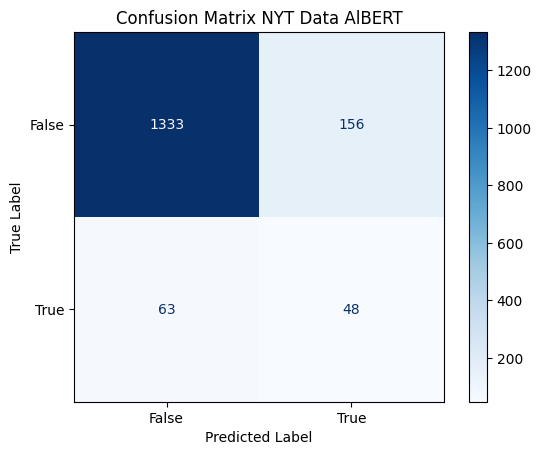

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Confusion matrix values
confusion_matrix = np.array([[1333, 156], [63, 48]])

# Display labels (optional, set to None if not needed)
display_labels = ["False", "True"]

# Create the display
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=display_labels)

# Plot the confusion matrix
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix NYT Data AlBERT")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


# **Make predictions with the model**

In [ ]:

#model_type="bert"
#model_name="google-bert/bert-base-uncased" #This may be a Hugging Face Transformers compatible pre-trained model, a community model, or the path to a directory containing model files. (ref to https://simpletransformers.ai/docs/classification-models/ )
model_path=f"/content/drive/MyDrive/InfoRet/models/{model_name}/best_model/"

model_type="roberta" #mlm _restrucer of model
model_name="FacebookAI/roberta-base"

#model_type="albert" #mlm+sop _restrucer of model
#model_name="albert/albert-base-v2"

model = MultiLabelClassificationModel(model_type, model_path)
# predictions, _ = model.predict(test_df['sentence'].tolist())
predictions, raw_outputs = model.predict(["factory farming allows for the production of cheap food, which is a necessity for families surviving on a low income. against We should ban factory farming"])
predictions

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0]]

In [ ]:
values = [
    "Self-direction: thought",
    "Self-direction: action",
    "Stimulation",
    "Hedonism",
    "Achievement",
    "Power: dominance",
    "Power: resources",
    "Face",
    "Security: personal",
    "Security: societal",
    "Tradition",
    "Conformity: rules",
    "Conformity: interpersonal",
    "Humility",
    "Benevolence: caring",
    "Benevolence: dependability",
    "Universalism: concern",
    "Universalism: nature",
    "Universalism: tolerance",
    "Universalism: objectivity"
]
def get_labels(values, output):
    # Initialize an empty list to store labels
    labels = []

    # Iterate over the output list and the corresponding values
    for idx, val in enumerate(output[0]):
        # If the value is 1, append the corresponding label to the list
        if val == 1:
            labels.append(values[idx])

    return labels



# Get the labels where the output value is 1
labels = get_labels(values, predictions)
print(labels)


['Security: personal', 'Security: societal', 'Benevolence: caring', 'Universalism: concern']
